# Getting started with CoAuthor

**Goal: Download and read the CoAuthor dataset**

Steps
1. Download CoAuthor
2. Read writing sessions
3. Examine events

Below sections of this .ipynb come from code from CoAuthor [LINKED HERE](https://colab.research.google.com/drive/1nUGXP9l_jelbB4X65J0ivUvLgQz1RK1C?usp=sharing)

* Download CoAuthor
* Read writing sessions
* Examine events



## 1. Download CoAuthor

In [1]:
!wget https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip
!unzip -q chi2022-coauthor-v1.0.zip
!rm chi2022-coauthor-v1.0.zip

zsh:1: command not found: wget
unzip:  cannot find or open chi2022-coauthor-v1.0.zip, chi2022-coauthor-v1.0.zip.zip or chi2022-coauthor-v1.0.zip.ZIP.
rm: chi2022-coauthor-v1.0.zip: No such file or directory


In [3]:
import os

dataset_dir = '../Data/coauthor-v1.0'
paths = [
    os.path.join(dataset_dir, path)
    for path in os.listdir(dataset_dir)
    if path.endswith('jsonl')
]

print(f'Successfully downloaded {len(paths)} writing sessions in CoAuthor!')

Successfully downloaded 1447 writing sessions in CoAuthor!


## 2. Read writing sessions

Each writing session is saved as a `.jsonl` file in CoAuthor.
It is a very convenient format to store events occured in the writing session: each line is a JSON object, representing an *event*, and there are many lines in the file, representing *a sequence of events*.

Let's read one of the files and see what it looks like!

> `.jsonl` is the JSON Lines text format. It is convenient for storing structured data that may be processed one record at a time. For more information, please refer to https://jsonlines.org/.

In [4]:
import json

def read_writing_session(path):
    events = []
    with open(path, 'r') as f:
        for event in f:
            events.append(json.loads(event))
    print(f'Successfully read {len(events)} events in a writing session from {path}')
    return events

In [5]:
events = read_writing_session(paths[0])

Successfully read 3045 events in a writing session from ../Data/coauthor-v1.0/e0435f4cf6fc435c872ffc5b66b66b0c.jsonl


## 3. Examine events

Whenever writers insert or delete text, move a cursor forward or backward, get suggestions from the system by pressing the tab key, or accept or dismiss suggestions, it is recorded as an event.

> Here is a list of all possible events in CoAuthor:
* `system-initialize`
* `text-insert`
* `text-delete`
* `cursor-forward`
* `cursor-backward`
* `cursor-select`
* `suggestion-get`
* `suggestion-open`
* `suggestion-up`
* `suggestion-down`
* `suggestion-select`
* `suggestion-close`

For more details, please check out our paper (Table 1): https://arxiv.org/pdf/2201.06796.pdf

In [6]:
event_names = [event['eventName'] for event in events]
event_names[:10]

['system-initialize',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-delete',
 'text-delete',
 'text-delete',
 'text-insert',
 'text-insert',
 'text-insert']

Let's look at each *event* more closely now!

In the beginning of a writing session, you will see something like this for a system-initialize event:

In [7]:
events[0]

{'eventName': 'system-initialize',
 'eventSource': 'api',
 'eventTimestamp': 1629097241033,
 'textDelta': '',
 'cursorRange': '',
 'currentDoc': 'A woman has been dating guy after guy, but it never seems to work out. She’s unaware that she’s actually been dating the same guy over and over; a shapeshifter who’s fallen for her, and is certain he’s going to get it right this time.\n\nOne day,\n',
 'currentCursor': 244,
 'currentSuggestions': [],
 'currentSuggestionIndex': 0,
 'currentHoverIndex': '',
 'currentN': '5',
 'currentMaxToken': '30',
 'currentTemperature': '0.3',
 'currentTopP': '1',
 'currentPresencePenalty': '0',
 'currentFrequencyPenalty': '0',
 'eventNum': 0}

Concretely, an *event* is a tuple of event name, timestamp, and snapshot of the current editor.
This is designed to preserve every detail about interactions at a keystroke-level, so it is quite detailed as you can see!

> **Event and its metadata**
* `eventName`: event name (e.g. `system-initialize`)
* `eventSource`: event source (e.g. `user` or `api`)
* `textDelta`: text that has been changed compared to the previous event (if no change, empty)
* `cursorRange`: cursor location or selection that has been changed compared to the previous event (if no change, empty)

> **Timestamp**
* `eventTimestamp`: timestamp of the event
* `eventNum`: index of the event

> **Snapshot of the current editor**
* Editor
  * `currentDoc`: a writing prompt to start with (otherwise, empty)
  * `currentCursor`: cursor location
  * `currentSuggestions`: most recent suggestions that are stored and can be reopened
* Decoding parameters
  * `currentN`: the number of suggestions to generate per query (e.g. 5)
  * `currentMaxToken`: the maximum number of tokens to generate per suggestion
  * `currentTemperature`: sampling temperature to use for generation; higher values means the model will take more risks
  * `currentTopP`: nucleus sampling; the model considers the results of the tokens with top_p probability mass
  * `currentPresencePenalty`: positive values penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics
  * `currentFrequencyPenalty`: positive values penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim


For more details on decoding parameters, please refer to https://beta.openai.com/docs/api-reference/completions.

## 4. Detecting Tone

Here we use RoBERTa GoEmotions for our emotion classifier. Downloading the model here.

In [10]:
from transformers import pipeline

# Load emotion classification model
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

/Users/esthergoldberg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/esthergoldberg/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [ ]:
text = "The weather is especially warm today."
result = emotion_classifier(text)
print(result)

[[{'label': 'anger', 'score': 0.06616844981908798}, {'label': 'disgust', 'score': 0.13412681221961975}, {'label': 'fear', 'score': 0.01607241854071617}, {'label': 'joy', 'score': 0.009524280205368996}, {'label': 'neutral', 'score': 0.3987541198730469}, {'label': 'sadness', 'score': 0.36784031987190247}, {'label': 'surprise', 'score': 0.007513641845434904}]]


Function to get the emotion label and score for top six emotions: anger, disgust, fear, joy, neutral, sadness, and surprise

In [ ]:
def get_emotion_vector(text):
  result = emotion_classifier(text)[0]
  scores = {emotion['label']: emotion['score'] for emotion in result}
  return scores, np.array(list(scores.values()))

## 5. Calculating Similarity of Tone Vectors - Jensen-Shannon Divergence (JSD)

Here I am downloading Jensen-Shannon Divergence as the method to calculate similarity of the tone portfolios that we will capture with Go Emotions.

In [ ]:
from scipy.spatial.distance import jensenshannon

def similarity_jsd(vector1, vector2):
    ''' Calculate JSD similarity between two vectors.'''
    jsd =  jensenshannon(vector1, vector2)
    similarity = 1 - jsd
    return similarity

In [ ]:
import numpy as np
prompt = "I love when my dogs are excited to go for a walk. It makes the walks much more enjoyable."
suggestion = "That is why I always bring their favorite stuffed animals out to get them ready to go for a fun walk."

score1, v1 = get_emotion_vector(prompt)
score2, v2 = get_emotion_vector(suggestion)
similarity_jsd(v1, v2)

0.6319316171294749

In [ ]:
print(score1)
print(v1)

{'anger': 0.0022996123880147934, 'disgust': 0.0035732020623981953, 'fear': 0.00047727618948556483, 'joy': 0.9764875173568726, 'neutral': 0.011999444104731083, 'sadness': 0.0032281221356242895, 'surprise': 0.0019348839996382594}
[2.29961239e-03 3.57320206e-03 4.77276189e-04 9.76487517e-01
 1.19994441e-02 3.22812214e-03 1.93488400e-03]


In [ ]:
print(score2)
print(v2)

{'anger': 0.009798532351851463, 'disgust': 0.008384371176362038, 'fear': 0.0014324390795081854, 'joy': 0.5880451202392578, 'neutral': 0.3717357814311981, 'sadness': 0.006140437442809343, 'surprise': 0.014463272877037525}
[0.00979853 0.00838437 0.00143244 0.58804512 0.37173578 0.00614044
 0.01446327]


## 6. Creating and Visualizing Tone Similarity between CoAuthor Prompts

In [ ]:
# understanding what each event contains
events[523]

{'eventName': 'text-insert',
 'eventSource': 'user',
 'eventTimestamp': 1629953466595,
 'textDelta': {'ops': [{'retain': 1402}, {'insert': 'o'}]},
 'cursorRange': '',
 'currentDoc': '',
 'currentCursor': 1403,
 'currentSuggestions': [],
 'currentSuggestionIndex': 0,
 'currentHoverIndex': 0,
 'currentN': '5',
 'currentMaxToken': '30',
 'currentTemperature': '0.2',
 'currentTopP': '1',
 'currentPresencePenalty': '0',
 'currentFrequencyPenalty': '0.5',
 'eventNum': 523}


User Input (User-Generated Text)
*   text-insert
*   text-delete

AI Suggestions (Model-Generated Text)
*   suggestion-get
*   suggestion-open
*  suggestion-select






This chunk of code combines the previous tasks, including finding tone and similarity between two tones and calculating it for every event.

In [ ]:
from collections import defaultdict

def reconstruct_user_text(events):
    ''' Creates text from events by combining text-insert and text-delete events.'''
    user_texts = []
    current_text = ""

    # Sort events by eventNum
    sorted_events = sorted(events, key=lambda e: e["eventNum"])

    for event in sorted_events:
        event_type = event["eventName"]
        text_delta = event["textDelta"]

        if event_type == "text-insert" and text_delta:
            extracted_text = ""
            for op in text_delta['ops']:
                if 'insert' in op:
                    extracted_text += op['insert']
            current_text += extracted_text

        elif event_type == "text-delete" and text_delta:
            delete_len = 0
            for op in text_delta['ops']:
                if 'delete' in op:
                    delete_len += op['delete']
                elif 'retain' in op:
                    pass
            current_text = current_text[:-delete_len]


        # Store finalized text if user completes a thought
        if event_type == "suggestion-get" or event_type == "suggestion-select":
            if current_text.strip():
                user_texts.append(current_text.strip())
                current_text = ""

    return user_texts

# Process all valid events
user_texts = reconstruct_user_text(events)

print(f"Total reconstructed user-written sentences: {len(user_texts)}")
print("Example user-written sentence:", user_texts)  # Show first 3 examples

Total reconstructed user-written sentences: 3
Example user-written sentence: ['college athletes should be paid over and above their scholorships.aThey should be paid a percentage of ticket sales. I do not agree that the broader community would be harmed. This is real life. Times change. It is fair that if the college makes a great sum of income, that some of it go to the players. Colleges in bidding wars? They do that anyway, but without money. They bid for the best. The athletes would receive no compensation until they graduate, again, which would be a percentage of tickets sold. \n\nIf colleges did not profit on their athletes, then no, they should not be paid. I think this is the best solution of all. This way, anyone can go to a game that they might not have otherwise been able to afford.', 'Having good sports is a boon to the colleges. They get televised or broadcasted which increases brand awareness. There are some thin, creating good will in the community.s that are hard to meas

This function is used to get the ai-suggestions

In [ ]:
def extract_selected_ai_suggestions(events):
    ai_suggestions = []  # Stores accepted AI-generated suggestions
    last_suggestion_open = None  # Store the most recent `suggestion-open` event

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save latest `suggestion-open` event

        elif event["eventName"] == "suggestion-select":
            if last_suggestion_open and last_suggestion_open.get("currentSuggestions"):
                selected_index = event.get("currentSuggestionIndex", -1)

                # Ensure selected index is valid
                if 0 <= selected_index < len(last_suggestion_open["currentSuggestions"]):
                    selected_suggestion = last_suggestion_open["currentSuggestions"][selected_index]["trimmed"]
                    ai_suggestions.append(selected_suggestion)

    return ai_suggestions

# Process all valid events
ai_suggestions = extract_selected_ai_suggestions(events)

print(f"Total AI Suggestions Accepted: {len(ai_suggestions)}")
print("Example AI Suggestion:", ai_suggestions[:3])  # Show first 3 examples


Total AI Suggestions Accepted: 1
Example AI Suggestion: ['college athletes should be paid.']


Here you can run this code to create a dataframe which contains the user text, ai-suggestion, and the tone similarity score.

In [ ]:
import pandas as pd
jsd_results = []
small = paths[100:110]
for path in small:
    events = read_writing_session(path)

    # Extract user-written text and AI-generated suggestions
    user_texts = reconstruct_user_text(events)
    ai_suggestions = extract_selected_ai_suggestions(events)
    print(f"User-written sentences: {user_texts}")
    print(f"AI-generated suggestions: {ai_suggestions}")

    # Ensure we only compare matching pairs
    for user_text, ai_text in zip(user_texts, ai_suggestions):
        user_score, user_vector = get_emotion_vector(user_text)
        ai_score, ai_vector = get_emotion_vector(ai_text)

        # Compute JSD similarity
        jsd_similarity = similarity_jsd(user_vector, ai_vector)

        # Store results
        jsd_results.append({
            "path": path,
            "user_text": user_text,
            "ai_suggestion": ai_text,
            "jsd_similarity": jsd_similarity
        })

# Save results to CSV
df_results = pd.DataFrame(jsd_results)

print(f"Processed {len(paths)} paths. Results saved to emotion_similarity_results.csv.")

Successfully read 2215 events in a writing session from ./coauthor-v1.0/bac237f54fe449e18334a685c6381657.jsonl
User-written sentences: ['dating apps and technology in general have paved the way to bridge closer connections together than', 'ever before. Because of dating apps such as Tinder, Facebook', ', Instagram, Snapchat, and other social media platforms, people are able to connect with each other in ways that were not possible before. Imagine before where two strangers could only meet by chance on a particular instance, nowadays we are', "able to connect with people from all over the world. It's almost as if it's cheating to find the one and what most people call,", 'your soulmate.\n\nOf course being too distracted and neglecting to spend time with your loved ones if you use these dating apps too often can be a negative. But so is', 'anything else that you do in excess. So the usage of technology must come with a great', 'balance and moderation. This way,', 'you can still enjoy the

This is used to better understand the distribution of `event_name` in a path.

In [ ]:
from collections import Counter

event_counts = Counter()

# Check event type distribution
for path in paths[:100]:  # Only first 100 paths
    events = read_writing_session(path)
    for event in events:
        event_counts[event["eventName"]] += 1

print("Event Distribution in First 100 Paths:")
for event_name, count in event_counts.items():
    print(f"{event_name}: {count}")

Successfully read 1238 events in a writing session from ./coauthor-v1.0/9614fb65fa5146549e303e13586a947b.jsonl
Successfully read 2431 events in a writing session from ./coauthor-v1.0/6c16f972111c483a9d45114c12e381ff.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 946 events in a writing session from ./coauthor-v1.0/5d9be2dad6584ff4b2ab1c6f701f64cb.jsonl
Successfully read 1247 events in a writing session from ./coauthor-v1.0/08b1a2012f4d4115b56cc8231449ff48.jsonl
Successfully read 1994 events in a writing session from ./coauthor-v1.0/b4bbf40667d64a6ebd248ebb87a3ce5f.jsonl
Successfully read 1830 events in a writing session from ./coauthor-v1.0/423daa7fb2214d1093f73d4966240646.jsonl
Successfully read 1876 events in a writing session from ./coauthor-v1.0/54c597f302a9404caab702a8499b8aa0.jsonl
Successfully read 1902 events in a writing session from ./coauthor-v1.0/b30082b36e764dbd859c020b10fe78b5.jsonl
Su

In [ ]:
#looking at event where eventName is suggestion-select
for event in events:
  if event['eventName'] == 'suggestion-open':
    print(event)
  if event['eventName'] == 'suggestion-select':
    print(event)
  if event['eventName'] == 'suggestion-close':
    print(event)


{'eventName': 'suggestion-open', 'eventSource': 'api', 'eventTimestamp': 1629211886380, 'textDelta': '', 'cursorRange': '', 'currentDoc': '', 'currentCursor': 268, 'currentSuggestions': [{'index': 0, 'original': 'The mother pig told her children that it was up to them to find food for themselves, and after a while, they did.', 'trimmed': 'The mother pig told her children that it was up to them to find food for themselves, and after a while, they did.', 'probability': 2.913180129804097e-16}, {'index': 1, 'original': 'One of these pigs was a particularly slow eater and, like all the others, he had to compete with his siblings for the best food.', 'trimmed': 'One of these pigs was a particularly slow eater and, like all the others, he had to compete with his siblings for the best food.', 'probability': 7.04791018239159e-23}, {'index': 2, 'original': 'After all, these were pigs that did not like to be dirty and were quite fastidious about their personal hygiene.', 'trimmed': 'After all, th

## 7. Visualizing Results

In [ ]:
# highest and lowest 5 similarity scores and text
highest_5 = df_results.nlargest(5, 'jsd_similarity')
lowest_5 = df_results.nsmallest(5, 'jsd_similarity')
print("Highest 5 Similarity Scores:")
for index, row in highest_5.iterrows():
    print(f"Score: {row['jsd_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


print("\nLowest 5 Similarity Scores:")
for index, row in lowest_5.iterrows():
    print(f"Score: {row['jsd_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


Highest 5 Similarity Scores:
Score: 0.9334847355498482
User Text: anything else that you do in excess. So the usage of technology must come with a great
AI Suggestion: write a letter and send it through snail mail.
Score: 0.9126603732285772
User Text: You spend many nights and days working in your lab trying to perfect the drug. When it has finally been perfected you
AI Suggestion: You are hailed as the savior of humanity.
Score: 0.9074325625204404
User Text: You have decided to create a new drug that will counteract the effects of the immortality drug.
AI Suggestion: decide to test it out on yourself.
Score: 0.8987753944548746
User Text: sat, and he waited, and he ate. He got fat as a pig, which in this case, him already being fat as a pig, meant he was as fat as
AI Suggestion: he saw the normal wolf pack which had been living there, completely oblivious to his existence.
Score: 0.8932217366719556
User Text: Choosing depleted uranium wasn't 92's first choice of building material,
AI S

Function to identify whether the user accepted or rejected a suggestion from ai.

In [ ]:
def extract_acceptance_status(events):
    """Track if a suggestion was accepted or rejected."""
    acceptance_status = []  # Stores 'accepted' or 'rejected'
    last_suggestion_open = None  # Store the most recent `suggestion-open`

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save the latest `suggestion-open`

        elif event["eventName"] == "suggestion-select" and last_suggestion_open:
            # Suggestion selected
            acceptance_status.append('accepted')
            last_suggestion_open = None  # Reset, since we handled the acceptance

        elif event["eventName"] == "suggestion-close" and last_suggestion_open:
            # Suggestion closed without selection (rejected)
            acceptance_status.append('rejected')
            last_suggestion_open = None  # Reset, since we handled the rejection

    return acceptance_status

Create a dataframe with user text, ai-suggestion, tone similarity, and

In [ ]:
# Loop through each path (limited to paths 100-110)
for path in paths[:100]:
    events = read_writing_session(path)

    if len(events) < 3000:

      # Extract user-written text and AI-generated suggestions
      user_texts = reconstruct_user_text(events)
      ai_suggestions = extract_selected_ai_suggestions(events)
      acceptance_status = extract_acceptance_status(events)

      # Ensure we only compare matching pairs
      for user_text, ai_text, status in zip(user_texts, ai_suggestions, acceptance_status):
          user_score,user_vector = get_emotion_vector(user_text)
          ai_score,ai_vector = get_emotion_vector(ai_text)

          # Compute JSD similarity
          jsd_similarity = similarity_jsd(user_vector, ai_vector)

          # Store results, including acceptance status
          jsd_results.append({
              "path": path,
              "user_text": user_text,
              "ai_suggestion": ai_text,
              "tone_similarity": jsd_similarity,
              "acceptance_status": status
          })


Successfully read 1238 events in a writing session from ./coauthor-v1.0/9614fb65fa5146549e303e13586a947b.jsonl
Successfully read 2431 events in a writing session from ./coauthor-v1.0/6c16f972111c483a9d45114c12e381ff.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 946 events in a writing session from ./coauthor-v1.0/5d9be2dad6584ff4b2ab1c6f701f64cb.jsonl
Successfully read 1247 events in a writing session from ./coauthor-v1.0/08b1a2012f4d4115b56cc8231449ff48.jsonl
Successfully read 1994 events in a writing session from ./coauthor-v1.0/b4bbf40667d64a6ebd248ebb87a3ce5f.jsonl
Successfully read 1830 events in a writing session from ./coauthor-v1.0/423daa7fb2214d1093f73d4966240646.jsonl
Successfully read 1876 events in a writing session from ./coauthor-v1.0/54c597f302a9404caab702a8499b8aa0.jsonl
Successfully read 1902 events in a writing session from ./coauthor-v1.0/b30082b36e764dbd859c020b10fe78b5.jsonl
Su

TypeError: can only concatenate str (not "dict") to str

In [ ]:
# Save results to CSV
df_results_with_acceptances = pd.DataFrame(jsd_results)

print(f"Processed {len(small)} paths. Results saved to emotion_similarity_with_acceptance.csv.")


Processed 10 paths. Results saved to emotion_similarity_with_acceptance.csv.


Looking at the highest and lowest 5 similarity scores

In [ ]:
# highest and lowest 5 similarity scores and text
#highest five after similarity of 1
highest_5 = df_results_with_acceptances[df_results_with_acceptances['jsd_similarity'] < 1].nlargest(5, 'jsd_similarity')
lowest_5 = df_results_with_acceptances.nsmallest(5, 'jsd_similarity')
print("Highest 5 Similarity Scores:")
for index, row in highest_5.iterrows():
    print(f"Score: {row['jsd_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


print("\nLowest 5 Similarity Scores:")
for index, row in lowest_5.iterrows():
    print(f"Score: {row['jsd_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")

Highest 5 Similarity Scores:
Score: 0.9914896438307602
User Text: The other nations were afraid that if they went into isolation, the United States would use the bomb on them.
AI Suggestion: The United States, on the other hand, was afraid that if they didnt go into isolation, the other nations would use the bomb on them.
Score: 0.9880423588297578
User Text: HHaving discussed the topic honestly, with girls in a comfortable atmosphere and then only having to deal with girls who have been surprised by their first period thye studenThe topic T
AI Suggestion: Having discussed the topic honestly, with girls in a comfortable atmosphere and then only having to deal with girls who have been surprised by their first period
Score: 0.9859983272789506
User Text: Matt is shocked by this, but he is even more shocked when he finds out that Soeurette is actually pregnant.
AI Suggestion: He is even more shocked when he finds out that he is the father of the child.
Score: 0.982275227410622
User Text: th

### Visualizations

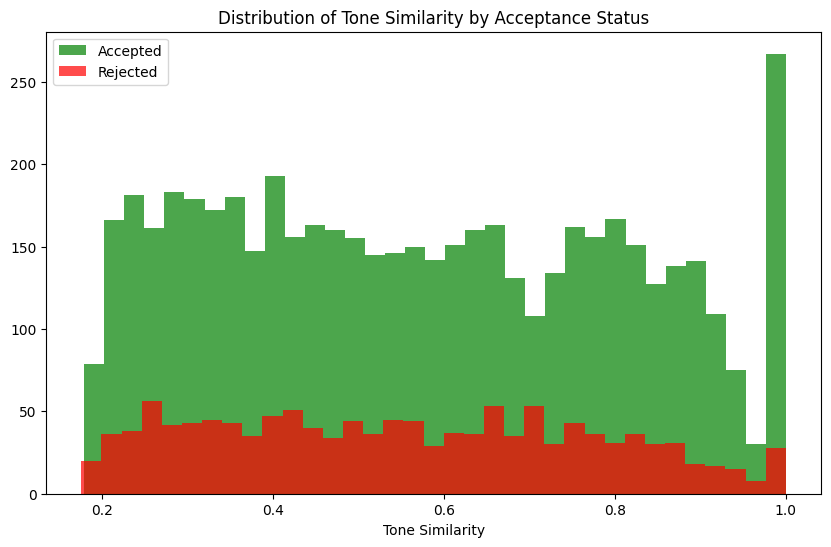

In [ ]:
# plot of similarity distribution by acceptance status
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_results_with_acceptances[df_results_with_acceptances['acceptance_status'] == 'accepted']['jsd_similarity'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results_with_acceptances[df_results_with_acceptances['acceptance_status'] == 'rejected']['jsd_similarity'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of Tone Similarity by Acceptance Status')
plt.xlabel('Tone Similarity')
plt.legend()

## 8. Looking into POS for user and ai-generated text

two different ways to analyze Part of Speech structure. By frequency and order.

In [ ]:
import spacy
from typing import List, Dict

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def get_pos_sequence(text):
    """Extracts the POS tag sequence from a given text."""
    doc = nlp(text)
    return [token.pos_ for token in doc]

def compare_pos_sequences(user_text, ai_text):
    """Compares POS tag sequences from user and AI text."""
    user_pos = get_pos_sequence(user_text)
    ai_pos = get_pos_sequence(ai_text)
    return {"user_pos": user_pos, "ai_pos": ai_pos}

def get_pos_frequencies(text):
    """Calculates the frequency of each POS tag in the given text."""
    pos_tags = get_pos_sequence(text)
    return dict(Counter(pos_tags))

def compare_pos_frequencies(user_text, ai_text):
    """Compares POS tag frequencies between user and AI text."""
    user_freq = get_pos_frequencies(user_text)
    ai_freq = get_pos_frequencies(ai_text)
    return {"user_freq": user_freq, "ai_freq": ai_freq}

# Example usage
user_text = "I love dancing with my friends because it is fun."
ai_text = "Dancing with my friends is enjoyable and stress-relieving."

pos_comparison = compare_pos_sequences(user_text, ai_text)
freq_comparison = compare_pos_frequencies(user_text, ai_text)

print("POS Tag Sequences:", pos_comparison)
print("POS Tag Frequencies:", freq_comparison)

POS Tag Sequences: {'user_pos': ['PRON', 'VERB', 'VERB', 'ADP', 'PRON', 'NOUN', 'SCONJ', 'PRON', 'AUX', 'ADJ', 'PUNCT'], 'ai_pos': ['VERB', 'ADP', 'PRON', 'NOUN', 'AUX', 'ADJ', 'CCONJ', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT']}
POS Tag Frequencies: {'user_freq': {'PRON': 3, 'VERB': 2, 'ADP': 1, 'NOUN': 1, 'SCONJ': 1, 'AUX': 1, 'ADJ': 1, 'PUNCT': 1}, 'ai_freq': {'VERB': 1, 'ADP': 1, 'PRON': 1, 'NOUN': 3, 'AUX': 1, 'ADJ': 1, 'CCONJ': 1, 'PUNCT': 2}}


Function to calculate cosine similarity between POS of texts

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity_pos(pos1, pos2):
    """Computes cosine similarity between POS tag frequency vectors."""
    pos1_freq = Counter(pos1)
    pos2_freq = Counter(pos2)

    # Create a sorted list of all POS tags in both texts
    all_tags = sorted(set(pos1_freq.keys()) | set(pos2_freq.keys()))

    # Convert frequency dictionaries into vectors
    vec1 = np.array([pos1_freq.get(tag, 0) for tag in all_tags]).reshape(1, -1)
    vec2 = np.array([pos2_freq.get(tag, 0) for tag in all_tags]).reshape(1, -1)

    # Compute cosine similarity
    return cosine_similarity(vec1, vec2)[0][0]

user_pos = get_pos_sequence(user_text)
ai_pos = get_pos_sequence(ai_text)

print(f"POS Tag Similarity: {cosine_similarity_pos(user_pos, ai_pos)}")

POS Tag Similarity: 0.6842105263157894


### MOST IMPORTANT
Creates the dataframe with user text, ai-suggestion, Tone similarity and POS similarity.

In [ ]:
# Loop through each path (limited to paths 100-110)
for path in paths[:100]:
    events = read_writing_session(path)

    if len(events) < 3000:

      # Extract user-written text and AI-generated suggestions
      user_texts = reconstruct_user_text(events)
      ai_suggestions = extract_selected_ai_suggestions(events)
      acceptance_status = extract_acceptance_status(events)

      # Ensure we only compare matching pairs
      for user_text, ai_text, status in zip(user_texts, ai_suggestions, acceptance_status):
          user_score,user_vector = get_emotion_vector(user_text)
          ai_score,ai_vector = get_emotion_vector(ai_text)

          # Compute JSD similarity
          jsd_similarity = similarity_jsd(user_vector, ai_vector)

          # Compute POS similarity
          user_pos = get_pos_sequence(user_text)
          ai_pos = get_pos_sequence(ai_text)
          pos_similarity = cosine_similarity_pos(user_pos, ai_pos)

          # Store results, including acceptance status
          jsd_results.append({
              "path": path,
              "user_text": user_text,
              "ai_suggestion": ai_text,
              "tone_similarity": jsd_similarity,
              "pos_similarity": pos_similarity,
              "acceptance_status": status
          })

# Save results to CSV
df_results_with_acceptances = pd.DataFrame(jsd_results)
df_results_with_acceptances.to_csv("Tone_POS_similarity.csv", index=False)

print(f"Processed {len(small)} paths. Results saved to emotion_similarity_with_acceptance.csv.")


Successfully read 1238 events in a writing session from ./coauthor-v1.0/9614fb65fa5146549e303e13586a947b.jsonl
Successfully read 2431 events in a writing session from ./coauthor-v1.0/6c16f972111c483a9d45114c12e381ff.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 946 events in a writing session from ./coauthor-v1.0/5d9be2dad6584ff4b2ab1c6f701f64cb.jsonl
Successfully read 1247 events in a writing session from ./coauthor-v1.0/08b1a2012f4d4115b56cc8231449ff48.jsonl
Successfully read 1994 events in a writing session from ./coauthor-v1.0/b4bbf40667d64a6ebd248ebb87a3ce5f.jsonl
Successfully read 1830 events in a writing session from ./coauthor-v1.0/423daa7fb2214d1093f73d4966240646.jsonl
Successfully read 1876 events in a writing session from ./coauthor-v1.0/54c597f302a9404caab702a8499b8aa0.jsonl
Successfully read 1902 events in a writing session from ./coauthor-v1.0/b30082b36e764dbd859c020b10fe78b5.jsonl
Su

### Visualizations

Text(0.5, 1.0, 'Scatter Plot of TONE Similarity vs. POS Similarity')

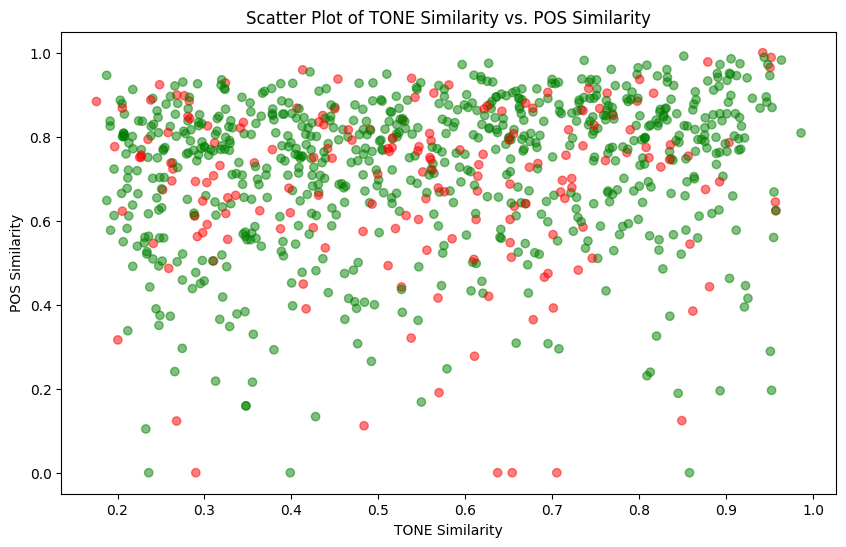

In [ ]:
df_results = df_results_with_acceptances[df_results_with_acceptances['jsd_similarity'] < 1]
df_results = df_results_with_acceptances[df_results_with_acceptances['pos_similarity'] < 1]
df_results = df_results.dropna()
df_results.to_csv("Tone_POS_similarity.csv", index=False)

colors = {'accepted': 'green', 'rejected': 'red'}

#plot tone and POS similarity
plt.figure(figsize=(10, 6))
plt.scatter(df_results['jsd_similarity'], df_results['pos_similarity'],
            alpha=0.5,
            c=df_results['acceptance_status'].map(colors))
plt.xlabel('TONE Similarity')
plt.ylabel('POS Similarity')
plt.title('Scatter Plot of TONE Similarity vs. POS Similarity')

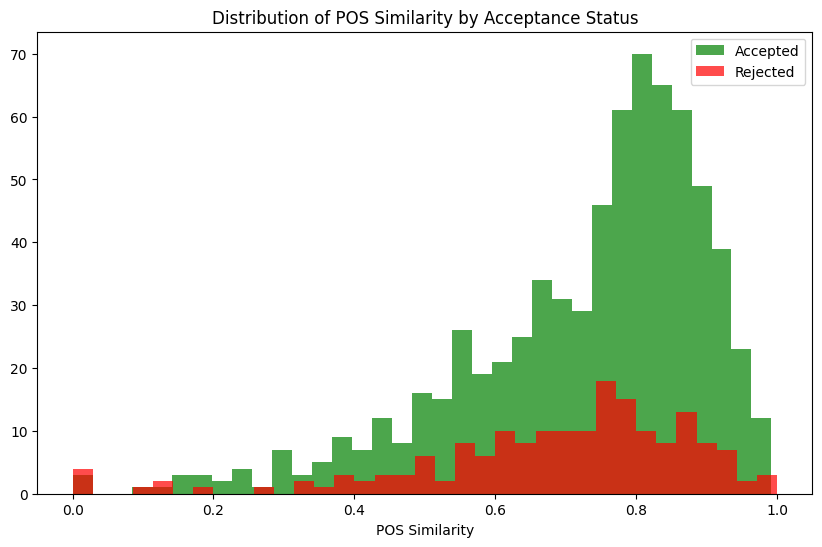

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_results[df_results['acceptance_status'] == 'accepted']['pos_similarity'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results[df_results['acceptance_status'] == 'rejected']['pos_similarity'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of POS Similarity by Acceptance Status')
plt.xlabel('POS Similarity')
plt.legend()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_results[df_results['acceptance_status'] == 'accepted']['jsd_similarity'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results[df_results['acceptance_status'] == 'rejected']['jsd_similarity'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of POS Similarity by Acceptance Status')
plt.xlabel('POS Similarity')
plt.legend()

## 9. T-Tests


In [ ]:
from scipy.stats import ttest_ind

# Separate data based on acceptance
accepted = df_results[df_results['acceptance_status'] == 'accepted']
rejected = df_results[df_results['acceptance_status'] == 'rejected']

# Run t-tests
t_jsd, p_jsd = ttest_ind(accepted['jsd_similarity'], rejected['jsd_similarity'], equal_var=False)
t_pos, p_pos = ttest_ind(accepted['pos_similarity'], rejected['pos_similarity'], equal_var=False)

# Print results
print(f"T-test for Tone Similarity: t = {t_jsd:.4f}, p = {p_jsd:.4f}")
print(f"T-test for POS Similarity: t = {t_pos:.4f}, p = {p_pos:.4f}")


T-test for Tone Similarity: t = 0.7651, p = 0.4448
T-test for POS Similarity: t = 2.5967, p = 0.0100
